In [106]:
import pandas as pd
import scipy as sc
import glob
import os
import json
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import colorConverter
import seaborn as sns

%load_ext autoreload
%autoreload 2
# %load_ext blackcellmagic
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [115]:
from constants import chemical_types
from constants import colors
from constants import experimental_deltaH
from bootstrap import bootstrap
import plotting

## Load in each system's energies and calculate the enthalpy by component

In [107]:
end_point_energies = {}
for system in systems:
    end_point_energies[system] = {}
    for ff in ["smirnoff", "bgbg_tip3p"]:
        try:
            with open(f"results/{system}-{ff}-enthalpy-full.json", "r") as f:
                 end_point_energies[system][ff] = json.load(f)
        except:
            pass

In [108]:
combined = pd.DataFrame()
for system in systems:
    guest = "-".join(system.split("-")[0:2])
    for ff in ["smirnoff", "bgbg_tip3p"]:

        if ff == "smirnoff":
            windows = ["a000", "r014"]
        else:
            windows = ["a00", "r00"]

        combined = combined.append(
            pd.DataFrame(
                {
                    "system": system,
                    "ff": ff,
                    "guest_type": guest_types[guest],
                    "total": end_point_energies[system][ff][windows[0]]["total"][0]
                    - end_point_energies[system][ff][windows[1]]["total"][0],
                    "bond": end_point_energies[system][ff][windows[0]]["bond"][0]
                    - end_point_energies[system][ff][windows[1]]["bond"][0],
                    "ang": end_point_energies[system][ff][windows[0]]["ang"][0]
                    - end_point_energies[system][ff][windows[1]]["ang"][0],
                    "dih": end_point_energies[system][ff][windows[0]]["dih"][0]
                    - end_point_energies[system][ff][windows[1]]["dih"][0],
                    "v14": end_point_energies[system][ff][windows[0]]["v14"][0]
                    - end_point_energies[system][ff][windows[1]]["v14"][0],
                    "e14": end_point_energies[system][ff][windows[0]]["e14"][0]
                    - end_point_energies[system][ff][windows[1]]["e14"][0],
                    "ele": end_point_energies[system][ff][windows[0]]["ele"][0]
                    - end_point_energies[system][ff][windows[1]]["ele"][0],
                    "vdw": end_point_energies[system][ff][windows[0]]["vdw"][0]
                    - end_point_energies[system][ff][windows[1]]["vdw"][0],
                    "total_sem": np.sqrt(
                        end_point_energies[system][ff][windows[0]]["total"][1] ** 2
                        + end_point_energies[system][ff][windows[1]]["total"][1] ** 2
                    ),
                    "bond_sem": np.sqrt(
                        end_point_energies[system][ff][windows[0]]["bond"][1] ** 2
                        + end_point_energies[system][ff][windows[1]]["bond"][1]**2
                    ),
                    "ang_sem": np.sqrt(
                        end_point_energies[system][ff][windows[0]]["ang"][1]**2
                       + end_point_energies[system][ff][windows[1]]["ang"][1]**2
                    ),
                    "dih_sem": np.sqrt(
                        end_point_energies[system][ff][windows[0]]["dih"][1]**2
                        + end_point_energies[system][ff][windows[1]]["dih"][1]**2
                    ),
                    "v14_sem": np.sqrt(
                        end_point_energies[system][ff][windows[0]]["v14"][1]**2
                        + end_point_energies[system][ff][windows[1]]["v14"][1]**2
                    ),
                    "e14_sem": np.sqrt(
                        end_point_energies[system][ff][windows[0]]["e14"][1]**2
                        + end_point_energies[system][ff][windows[1]]["e14"][1]**2
                    ),
                    "ele_sem": np.sqrt(
                        end_point_energies[system][ff][windows[0]]["ele"][1]**2
                        + end_point_energies[system][ff][windows[1]]["ele"][1]**2
                    ),
                    "vdw_sem": np.sqrt(
                        end_point_energies[system][ff][windows[0]]["vdw"][1]**2
                        + end_point_energies[system][ff][windows[1]]["vdw"][1]**2
                    ),
                },
                index=[0],
            ),
            ignore_index=True,
        )


In [111]:
combined.to_csv("results/computational_deltaH_by_orientation.csv")
computational_deltaH_by_orientation = combined

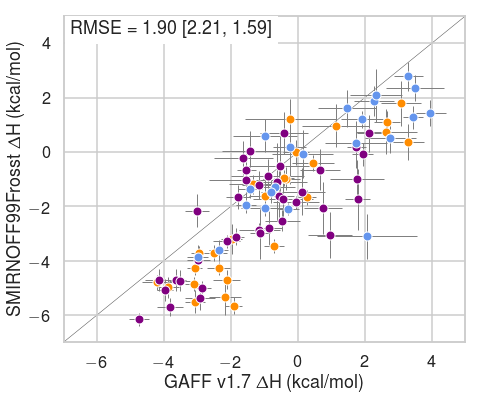

In [118]:
statistics = bootstrap(
    computational_deltaH_by_orientation[computational_deltaH_by_orientation["ff"] == "bgbg_tip3p"]["total"].values,
    computational_deltaH_by_orientation[computational_deltaH_by_orientation["ff"] == "bgbg_tip3p"]["total_sem"].values,
    computational_deltaH_by_orientation[computational_deltaH_by_orientation["ff"] == "smirnoff"]["total"].values,
    computational_deltaH_by_orientation[computational_deltaH_by_orientation["ff"] == "smirnoff"]["total_sem"].values,
    cycles=1000,
)

guest_types = computational_deltaH_by_orientation["guest_type"].unique()
fig, ax = plt.subplots(1, figsize=(6 * 1.2, 6))

for index, guest_type in enumerate(guest_types):
    df = computational_deltaH_by_orientation[computational_deltaH_by_orientation["guest_type"] == guest_type]
    df_x = df[df["ff"] == "bgbg_tip3p"]
    df_y = df[df["ff"] == "smirnoff"]
    ax.errorbar(
        df_x["total"],
        df_y["total"],
        xerr=df_x["total_sem"],
        yerr=df_y["total_sem"],
        fmt="o",
        c=colors[guest_type],
        markeredgecolor="w",
        ecolor="0.5",
        elinewidth=1,
    )
    
ax.plot([-50, 50], [-50, 50], ls="-", c=".3", zorder=-1, lw="0.5")
ax.set_ylim(-7, 5)
ax.set_xlim(-7, 5)
ax.set_ylabel("SMIRNOFF99Frosst $\Delta$H (kcal/mol)", labelpad=5)
ax.set_xlabel("GAFF v1.7 $\Delta$H (kcal/mol)", labelpad=5)

bbox_props = dict(boxstyle="square", fc="w", ec="k", lw=0.0, alpha=1)
text = f"RMSE = {statistics['mean']['RMSE']:0.2f} [{statistics['mean']['RMSE']+1.96*statistics['sem']['RMSE']:0.2f}, {statistics['mean']['RMSE']-1.96*statistics['sem']['RMSE']:0.2f}]"
ax.annotate(
    text,
    xy=(-7 + 0.21, 5 - 0.21),
    xycoords="data",
    size=18,
    bbox=bbox_props,
    horizontalalignment="left",
    verticalalignment="top",
)

plt.savefig("SMIRNOFF-vs-GAFF-deltaH.pdf")

total
{'mean': {'slope': 0.82140622516715989, 'intercept': -1.2545283119727542, 'R': 0.77420625610730143, 'R**2': 0.60185714450302008, 'RMSE': 1.9032158700476585}, 'sem': {'slope': 0.06809124517314144, 'intercept': 0.17378695618501866, 'R': 0.049616705929915302, 'R**2': 0.07532292877698446, 'RMSE': 0.15054551813030653}}
bond
{'mean': {'slope': 0.55091832626845572, 'intercept': -0.37645810346250846, 'R': 0.61104271649666309, 'R**2': 0.38101486449732519, 'RMSE': 0.34617259001813122}, 'sem': {'slope': 0.09643599977327745, 'intercept': 0.10129383976453916, 'R': 0.087416606624278484, 'R**2': 0.10397447612374382, 'RMSE': 0.042487052659605735}}
ang
{'mean': {'slope': 0.65713610803377631, 'intercept': -1.4068996159014775, 'R': 0.63589057956569328, 'R**2': 0.41230184508453754, 'RMSE': 1.5511436678490791}, 'sem': {'slope': 0.10328541424874195, 'intercept': 0.44938276372190539, 'R': 0.089134818696983725, 'R**2': 0.11106104082043393, 'RMSE': 0.20960390482728272}}
dih
{'mean': {'slope': 0.564205317

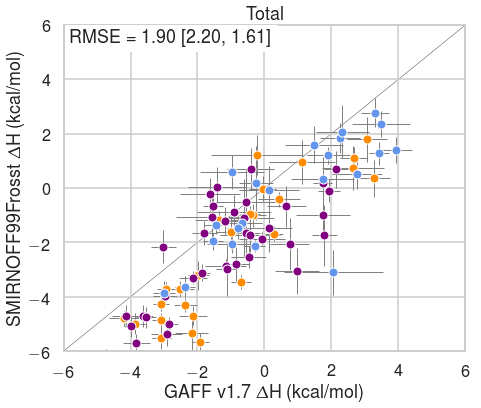

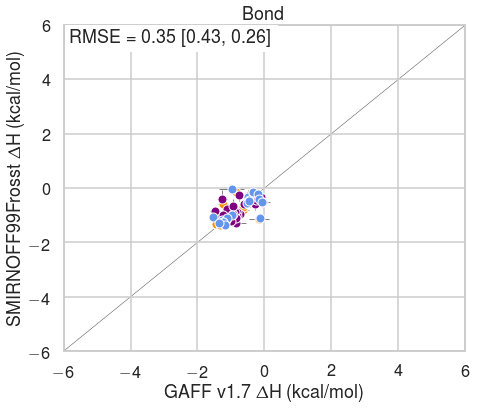

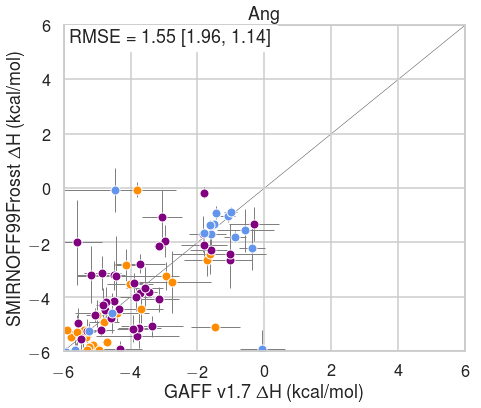

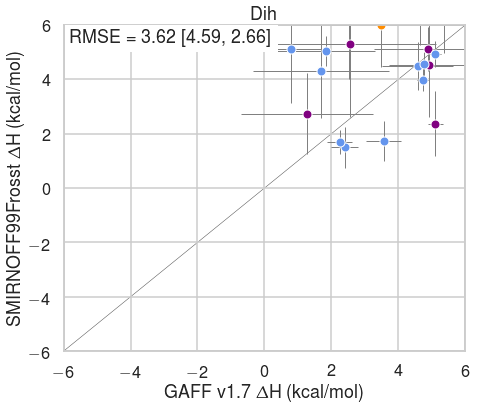

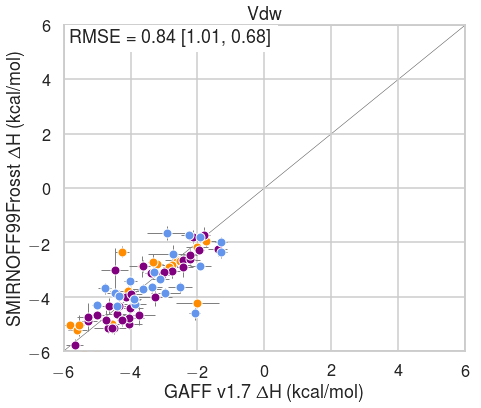

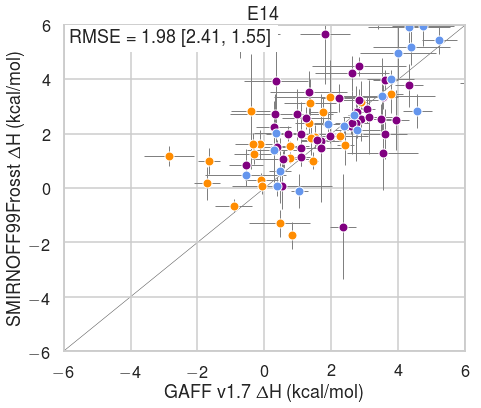

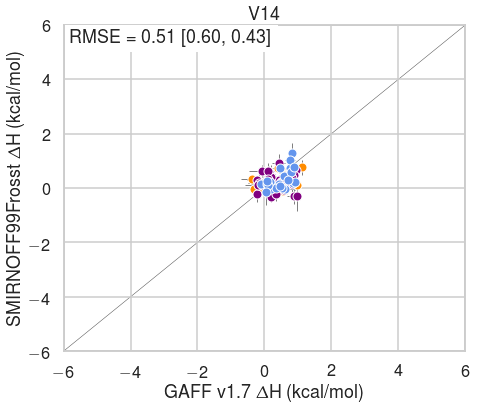

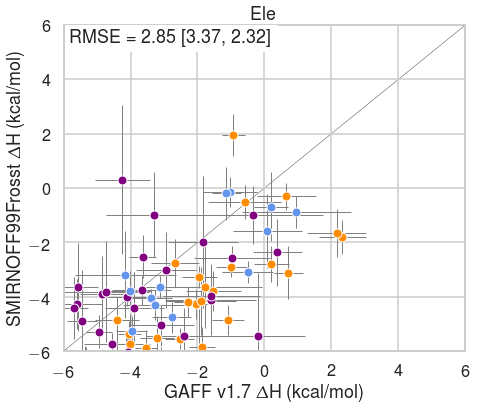

In [120]:
for component in ["total", "bond", "ang", "dih", "vdw", "e14", "v14", "ele"]:

    fig, ax = plt.subplots(1, figsize=(6 * 1.2, 6))

    for index, guest_type in enumerate(guest_types):
        df = computational_deltaH_by_orientation[computational_deltaH_by_orientation["guest_type"] == guest_type]
        df_x = df[df["ff"] == "bgbg_tip3p"]
        df_y = df[df["ff"] == "smirnoff"]
        ax.errorbar(
            df_x[component],
            df_y[component],
            xerr=df_x[f"{component}_sem"],
            yerr=df_y[f"{component}_sem"],
            fmt="o",
            c=colors[guest_type],
            markeredgecolor="w",
            ecolor="0.5",
            elinewidth=1,
        )

    smirnoff = computational_deltaH_by_orientation[computational_deltaH_by_orientation["ff"] == "smirnoff"]
    bgbg = computational_deltaH_by_orientation[computational_deltaH_by_orientation["ff"] == "bgbg_tip3p"]
    statistics = bootstrap(bgbg[component].values,
                   bgbg[f"{component}_sem"].values,
                   smirnoff[component].values,
                   smirnoff[f"{component}_sem"].values,
                   cycles=1000)
    print(component)
    print(statistics)
    
    text = f"RMSE = {statistics['mean']['RMSE']:0.2f} [{statistics['mean']['RMSE']+1.96*statistics['sem']['RMSE']:0.2f}, {statistics['mean']['RMSE']-1.96*statistics['sem']['RMSE']:0.2f}]"
    ax.annotate(
    text,
    xy=(-6+ 0.2, 6 - 0.2),
    xycoords="data",
    size=18,
    bbox=bbox_props,
    horizontalalignment="left",
    verticalalignment="top",
)

    ax.set_title(component.title())
    ax.plot([-50, 50], [-50, 50], ls="-", c=".3", zorder=-1, lw="0.5")
    ax.set_ylim(-6, 6)
    ax.set_xlim(-6, 6)
    ax.set_ylabel("SMIRNOFF99Frosst $\Delta$H (kcal/mol)", labelpad=5)
    ax.set_xlabel("GAFF v1.7 $\Delta$H (kcal/mol)", labelpad=5)

## Combine each orientation for SMIRNOFF and GAFF, and then join with the experimental data.

In [122]:
computational_deltaH_by_orientation["short_system"] = ["-".join(row["system"].split("-")[0:2]) for _, row in computational_deltaH_by_orientation.iterrows()]

In [123]:
smirnoff = pd.DataFrame()

for hg in computational_deltaH_by_orientation["short_system"].unique():
    df = computational_deltaH_by_orientation[(computational_deltaH_by_orientation["short_system"] == hg) & (computational_deltaH_by_orientation["ff"] == "smirnoff")]
    for _, row in df.iterrows():
        if "p" in row["system"].split("-")[2]:
            primary_fe = row["total"]
            primary_sem = row["total_sem"]
            guest_type = row["guest_type"]
        else:
            secondary_fe = row["total"]
            secondary_sem = row["total_sem"]
    results = thermodynamic_bootstrap(primary_fe, primary_sem,
                           secondary_fe, secondary_sem)
    print(f"{hg} P: {primary_fe:+0.4f} ± {primary_sem:+0.2f} S: {secondary_fe:+0.2f} ± {secondary_sem:+0.2f} → Boot: {results['mean']:+0.2f} ± {results['sem']:+0.2f}")
    
    smirnoff = smirnoff.append(pd.DataFrame({'system': hg,
                                 'smirnoff' : results['mean'],
                                 'smirnoff_sem': results['sem'],
                                 'guest_type': guest_type
                                 }, index=[0]), ignore_index=True)

a-bam P: -0.4158 ± +0.28 S: -1.19 ± +0.35 → Boot: -1.35 ± +0.27
a-but P: -1.8585 ± +0.24 S: -0.67 ± +0.64 → Boot: -1.97 ± +0.24
a-cbu P: -2.1144 ± +0.22 S: -2.05 ± +0.32 → Boot: -2.52 ± +0.20
a-chp P: -1.3761 ± +0.33 S: -3.62 ± +0.39 → Boot: -3.64 ± +0.38
a-cpe P: -1.2969 ± +0.35 S: -1.95 ± +0.31 → Boot: -2.15 ± +0.26
a-coc P: -1.4586 ± +0.41 S: -3.87 ± +0.46 → Boot: -3.89 ± +0.43
a-hep P: -4.7057 ± +0.41 S: -4.72 ± +0.40 → Boot: -5.20 ± +0.30
a-ham P: -3.7096 ± +0.29 S: -4.70 ± +0.34 → Boot: -4.83 ± +0.29
a-hp6 P: -5.0855 ± +0.40 S: -4.75 ± +0.39 → Boot: -5.40 ± +0.30
a-hex P: -5.3618 ± +0.45 S: -3.98 ± +0.28 → Boot: -5.44 ± +0.40
a-hx2 P: -4.9946 ± +0.24 S: -3.29 ± +0.24 → Boot: -5.03 ± +0.22
a-hpa P: -4.2650 ± +0.25 S: -5.34 ± +0.66 → Boot: -5.47 ± +0.55
a-mba P: -0.0197 ± +0.47 S: -0.99 ± +0.42 → Boot: -1.14 ± +0.36
a-hx3 P: -3.1135 ± +0.31 S: -2.17 ± +0.61 → Boot: -3.27 ± +0.29
a-mhp P: -4.9829 ± +0.39 S: -4.87 ± +0.26 → Boot: -5.40 ± +0.25
a-mha P: -4.2896 ± +0.26 S: -3.22 ± +0.5

In [124]:
gaff = pd.DataFrame()

for hg in computational_deltaH_by_orientation["short_system"].unique():
    df = computational_deltaH_by_orientation[(computational_deltaH_by_orientation["short_system"] == hg) & (computational_deltaH_by_orientation["ff"] == "bgbg_tip3p")]
    for _, row in df.iterrows():
        if "p" in row["system"].split("-")[2]:
            primary_fe = row["total"]
            primary_sem = row["total_sem"]
            guest_type = row["guest_type"]
        else:
            secondary_fe = row["total"]
            secondary_sem = row["total_sem"]
    results = thermodynamic_bootstrap(primary_fe, primary_sem,
                           secondary_fe, secondary_sem)
    print(f"{hg} P: {primary_fe:+0.4f} ± {primary_sem:+0.2f} S: {secondary_fe:+0.2f} ± {secondary_sem:+0.2f} → Boot: {results['mean']:+0.2f} ± {results['sem']:+0.2f}")
    
    gaff = gaff.append(pd.DataFrame({'system': hg,
                                 'bgbg_tip3p' : results['mean'],
                                 'bgbg_tip3p_sem': results['sem'],
                                 'guest_type': guest_type
                                 }, index=[0]), ignore_index=True)

a-bam P: +0.4380 ± +0.63 S: -1.35 ± +0.72 → Boot: -1.45 ± +0.66
a-but P: -0.0701 ± +0.69 S: -1.54 ± +0.29 → Boot: -1.63 ± +0.27
a-cbu P: -0.2842 ± +0.31 S: -0.98 ± +0.73 → Boot: -1.24 ± +0.53
a-chp P: -1.4365 ± +0.36 S: -2.37 ± +0.29 → Boot: -2.50 ± +0.25
a-cpe P: -0.6788 ± +0.60 S: -1.55 ± +0.30 → Boot: -1.74 ± +0.27
a-coc P: -0.7969 ± +0.31 S: -3.00 ± +0.32 → Boot: -3.02 ± +0.31
a-hep P: -3.6344 ± +0.30 S: -4.13 ± +0.42 → Boot: -4.39 ± +0.30
a-ham P: -2.5099 ± +0.40 S: -2.13 ± +0.42 → Boot: -2.83 ± +0.31
a-hp6 P: -3.9724 ± +0.23 S: -3.54 ± +0.30 → Boot: -4.23 ± +0.19
a-hex P: -2.9244 ± +0.45 S: -2.97 ± +0.35 → Boot: -3.43 ± +0.30
a-hx2 P: -2.8510 ± +0.26 S: -2.13 ± +0.41 → Boot: -3.04 ± +0.23
a-hpa P: -3.0882 ± +0.23 S: -2.18 ± +0.49 → Boot: -3.23 ± +0.21
a-mba P: -0.0572 ± +0.40 S: -0.35 ± +0.40 → Boot: -0.70 ± +0.30
a-hx3 P: -1.8584 ± +0.24 S: -3.02 ± +0.37 → Boot: -3.12 ± +0.32
a-mhp P: -3.8714 ± +0.30 S: -3.10 ± +0.27 → Boot: -4.04 ± +0.23
a-mha P: -2.3648 ± +0.35 S: -1.97 ± +0.3

In [127]:
computational = pd.merge(smirnoff, gaff, on=["system", "guest_type"])
computational.head()

,system,smirnoff,smirnoff_sem,guest_type,bgbg_tip3p,bgbg_tip3p_sem
0,a-bam,-1.351253,0.268649,aliphatic_ammoniums,-1.447531,0.661662
1,a-but,-1.965781,0.236466,aliphatic_carboxylates,-1.630305,0.267231
2,a-cbu,-2.521970,0.196257,cyclic_alcohols,-1.237794,0.532813
3,a-chp,-3.636282,0.378381,cyclic_alcohols,-2.502587,0.249217
4,a-cpe,-2.150959,0.262316,cyclic_alcohols,-1.744061,0.271493


In [144]:
from pandas.compat import StringIO
experimental_df = pd.read_csv(StringIO(experimental_deltaH), sep="\t", names=["system", "exp", "exp_sem"])
experimental_df.head()

,system,exp,exp_sem
0,a-bam,-2.17,0.05
1,a-nmb,-2.57,0.06
2,a-mba,-2.68,0.07
3,a-pam,-3.28,0.02
4,a-ham,-4.19,0.02


In [145]:
deltaH = pd.merge(computational, experimental_df, on=["system"])
deltaH.head()

,system,smirnoff,smirnoff_sem,guest_type,bgbg_tip3p,bgbg_tip3p_sem,exp,exp_sem
0,a-bam,-1.351253,0.268649,aliphatic_ammoniums,-1.447531,0.661662,-2.17,0.05
1,a-but,-1.965781,0.236466,aliphatic_carboxylates,-1.630305,0.267231,-2.53,0.12
2,a-cbu,-2.521970,0.196257,cyclic_alcohols,-1.237794,0.532813,-2.75,0.05
3,a-chp,-3.636282,0.378381,cyclic_alcohols,-2.502587,0.249217,-2.99,0.23
4,a-cpe,-2.150959,0.262316,cyclic_alcohols,-1.744061,0.271493,-2.74,0.02


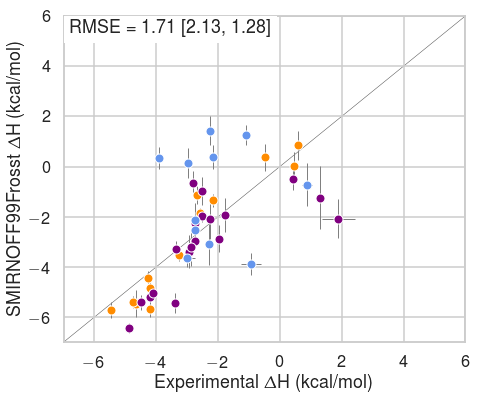

In [148]:
statistics = bootstrap(deltaH["exp"],
                       deltaH["exp_sem"],
                       deltaH["smirnoff"],
                       deltaH["smirnoff_sem"],
                       cycles=1000)

guest_types = deltaH["guest_type"].unique()
fig, ax = plt.subplots(1, figsize=(6 * 1.2, 6))

for index, guest_type in enumerate(guest_types):
    tmp = deltaH[deltaH["guest_type"] == guest_type]
    ax.errorbar(
        tmp["exp"],
        tmp["smirnoff"],
        xerr=tmp["exp_sem"],
        yerr=tmp["smirnoff_sem"],
        fmt="o",
        c=colors[guest_type],
        markeredgecolor="w",
        ecolor="0.5",
        elinewidth=1,
    )

ax.plot([-50, 50], [-50, 50], ls="-", c=".3", zorder=-1, lw="0.5")
ax.set_ylim(-7, 6)
ax.set_xlim(-7, 6)
ax.set_ylabel("SMIRNOFF99Frosst $\Delta$H (kcal/mol)", labelpad=5)
ax.set_xlabel("Experimental $\Delta$H (kcal/mol)", labelpad=5)
bbox_props = dict(boxstyle="square", fc="w", ec="k", lw=0.0, alpha=1)
text = f"RMSE = {statistics['mean']['RMSE']:0.2f} [{statistics['mean']['RMSE']+1.96*statistics['sem']['RMSE']:0.2f}, {statistics['mean']['RMSE']-1.96*statistics['sem']['RMSE']:0.2f}]"
ax.annotate(
    text,
    xy=(-7 + 0.2, 6 - 0.2),
    xycoords="data",
    size=18,
    bbox=bbox_props,
    horizontalalignment="left",
    verticalalignment="top",
)
plt.savefig("SMIRNOFF-vs-exp-deltaH.pdf")

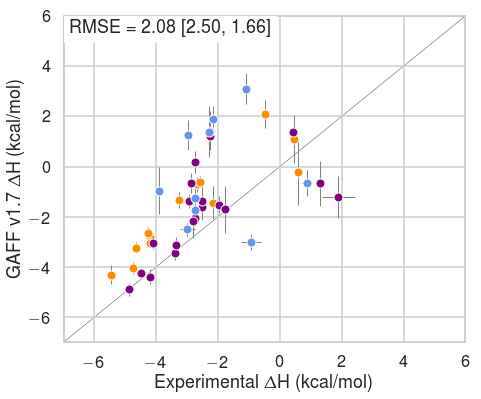

In [149]:
statistics = bootstrap(deltaH["exp"],
                       deltaH["exp_sem"],
                       deltaH["bgbg_tip3p"],
                       deltaH["bgbg_tip3p_sem"],
                       cycles=1000)

guest_types = deltaH["guest_type"].unique()
fig, ax = plt.subplots(1, figsize=(6 * 1.2, 6))

for index, guest_type in enumerate(guest_types):
    tmp = deltaH[deltaH["guest_type"] == guest_type]
    ax.errorbar(
        tmp["exp"],
        tmp["bgbg_tip3p"],
        xerr=tmp["exp_sem"],
        yerr=tmp["bgbg_tip3p_sem"],
        fmt="o",
        c=colors[guest_type],
        markeredgecolor="w",
        ecolor="0.5",
        elinewidth=1,
    )

ax.plot([-50, 50], [-50, 50], ls="-", c=".3", zorder=-1, lw="0.5")
ax.set_ylim(-7, 6)
ax.set_xlim(-7, 6)
ax.set_ylabel("GAFF v1.7 $\Delta$H (kcal/mol)", labelpad=5)
ax.set_xlabel("Experimental $\Delta$H (kcal/mol)", labelpad=5)
bbox_props = dict(boxstyle="square", fc="w", ec="k", lw=0.0, alpha=1)
text = f"RMSE = {statistics['mean']['RMSE']:0.2f} [{statistics['mean']['RMSE']+1.96*statistics['sem']['RMSE']:0.2f}, {statistics['mean']['RMSE']-1.96*statistics['sem']['RMSE']:0.2f}]"
ax.annotate(
    text,
    xy=(-7 + 0.2, 6 - 0.2),
    xycoords="data",
    size=18,
    bbox=bbox_props,
    horizontalalignment="left",
    verticalalignment="top",
)
plt.savefig("GAFF-vs-exp-deltaH.pdf")

In [151]:
ido = np.genfromtxt("/home/dslochower/Downloads/mcmd.csv")

In [152]:
%timeit np.mean(ido)

12.6 ms ± 132 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [153]:
np.mean(ido)

-14822.525454617022

In [154]:
np.std(ido)

77.066244929612211

In [156]:
pd.read_csv("/home/dslochower/Downloads/mcmd.csv")

,-14797.317966975650
0,-14797.317967
1,-14797.317967
2,-14797.317967
3,-14797.317967
4,-14797.317967
5,-14797.317967
6,-14797.317967
7,-14797.317967
8,-14797.317967
9,-14797.317967
